In [1]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [2]:
import torch
from torch.utils.data import DataLoader

import numpy as np
import tensorly as tl
import scipy.signal
import matplotlib.pyplot as plt
import copy

In [3]:
import sys
sys.path.append(r'/media/rich/Home_Linux_partition/github_repos')
%load_ext autoreload
%autoreload 2

import tensor_regression as tr
import tensor_regression.util
from tensor_regression import standard_tensor_regression as STR

import basic_neural_processing_modules as bnpm
from basic_neural_processing_modules import torch_helpers
from basic_neural_processing_modules import h5_handling
from basic_neural_processing_modules import timeSeries
from basic_neural_processing_modules import math_functions
from basic_neural_processing_modules import misc

In [4]:
%matplotlib notebook

In [5]:
dir_data = r'/media/rich/bigSSD/for_Josh/'
fileName_X_data = r'positions_convDR_meanSub_s2pInd.h5'
fileName_y_data = r'neural_data.h5'
positions = h5_handling.simple_load(directory=dir_data, fileName=fileName_X_data)
neural_data = h5_handling.simple_load(directory=dir_data, fileName=fileName_y_data)

In [6]:
torch_helpers.show_cuda_devices()
DEVICE = tr.util.set_device(use_GPU=True, verbose=True)

1 device(s) found.
0 GeForce RTX 3090
GPU is enabled.


In [7]:
pos_array = positions['positions_convDR_meanSub_s2pInd']
print(f'pos_array.shape = {pos_array.shape}')

pos_array.shape = (108000, 2744)


<IPython.core.display.Javascript object>


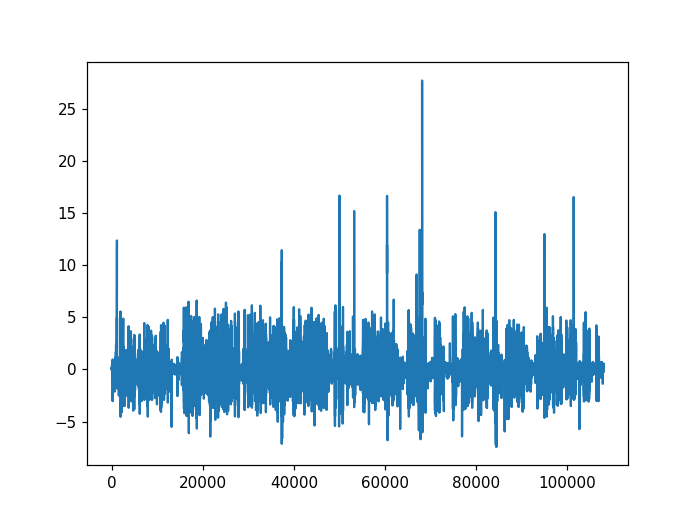

In [8]:
plt.figure()
plt.plot(pos_array[:,1200])

<IPython.core.display.Javascript object>


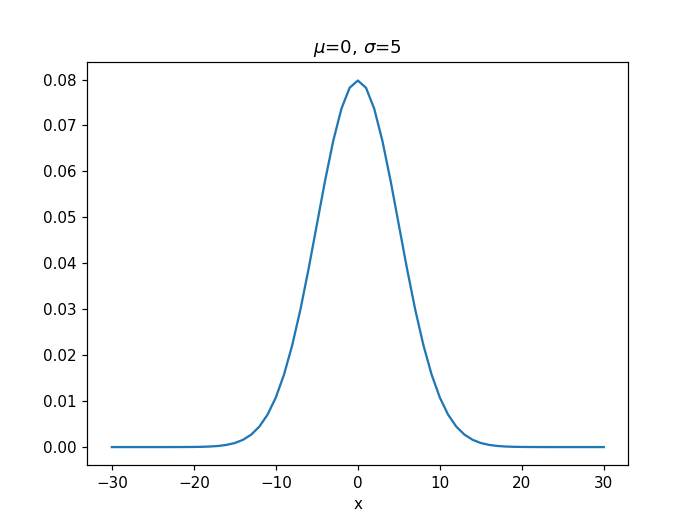

ThreadPool elapsed time : 0.17 s. Now unpacking list into array.
Calculated convolution. Total elapsed time: 0.33 seconds
neural_array.shape = (108000, 811)


In [9]:
ic = neural_data['is_cell']
good_ROIs = neural_data['good_ROIs']
spks = torch.tensor(neural_data['spks'][ic][good_ROIs]).T
dFoF = torch.tensor(neural_data['dFoF'][ic][good_ROIs]).T

gaussian_kernel , params_gaus = math_functions.gaussian(x=np.arange(-30,31,1),
                                                                  mu=0,
                                                                  sig=5,
                                                                  plot_pref=True)
spks_conv = timeSeries.convolve_along_axis(spks,
                                             gaussian_kernel,
                                             axis=0,
                                             mode='same',
                                             multicore_pref=True,
                                             verbose=True)

print(f'neural_array.shape = {spks_conv.shape}')

# win_range = [-120*3, -120*-1]
win_range = [-15, 15]

<IPython.core.display.Javascript object>


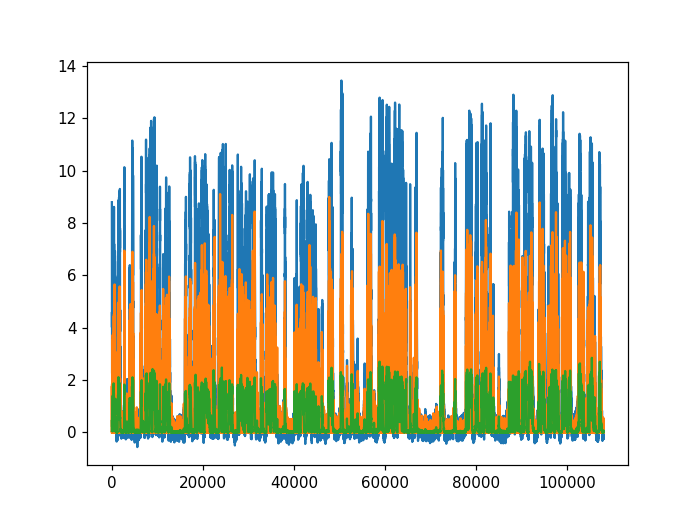

In [10]:
idx_toPlot = 5
plt.figure()
plt.plot(dFoF[:,idx_toPlot])
plt.plot(spks[:,idx_toPlot]/40)
plt.plot(spks_conv[:,idx_toPlot]/40)

In [11]:
## convert X time series into a time series of time window slices

input_array = pos_array - np.mean(pos_array, axis=1, keepdims=True)

win_len = 1 * 30
# win_len = 1
n_samples = input_array.shape[0]
slice_idx = np.arange(0, n_samples - win_len)
n_slices = len(slice_idx)
n_features = input_array.shape[1]

windowed_tensor = np.empty((n_slices, win_len, n_features), dtype=np.float32)
for ii, idx in enumerate(slice_idx + win_len//2):
#     ff_tensor[ii] = pos_array[idx:idx+win_len , :]
    windowed_tensor[ii] = pos_array[idx-win_len//2:idx+win_len//2 , :]
print(f'X tensor shape:{windowed_tensor.shape}')
print(f'X tensor size on disk:{sys.getsizeof(windowed_tensor)/1000000000} GB')

# X = copy.deepcopy(ff_tensor)


X tensor shape:(107970, 30, 2744)
X tensor size on disk:35.552361736 GB


In [13]:
X = torch.tensor(windowed_tensor[:80000,:,:], dtype=torch.float32)
# X = torch.tensor(windowed_tensor[:50000,:,:2744//3], dtype=torch.complex64)
y = torch.tensor(spks_conv[:80000,5], dtype=torch.float32)
y = y - y.mean()

print(f'X size: {misc.estimate_size_of_float_array(input_shape=X.shape, bitsize=32)/1000000000} GB')
print(f'y size: {misc.estimate_size_of_float_array(input_shape=y.shape, bitsize=32)/1000000000} GB')

X size: 26.3424 GB
y size: 0.00032 GB


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


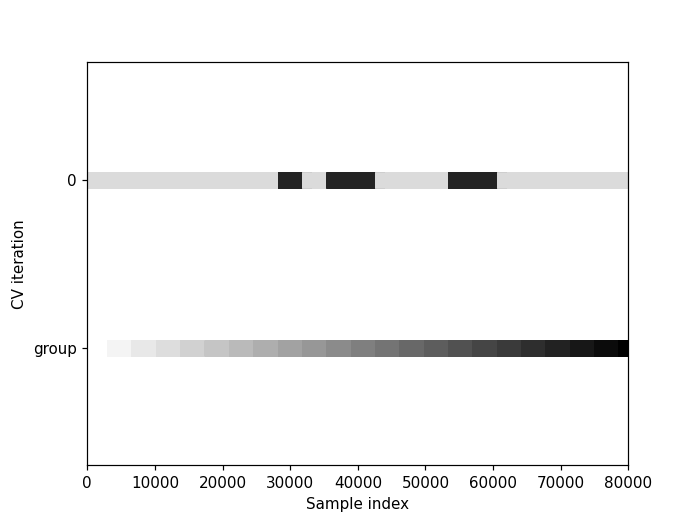

In [14]:
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import cross_validation

from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                 StratifiedKFold, GroupShuffleSplit,
                                 GroupKFold, StratifiedShuffleSplit)
Fs = 30
group_len = 60*2 * Fs # seconds * Fs
n_splits = 1
test_size = 0.2
groups = np.arange(X.shape[0])//group_len
n_groups = np.max(groups)
cv = GroupShuffleSplit(n_splits, test_size=test_size)
cv_idx_all = cross_validation.make_cv_indices(cv,
                                        groups,
                                        lw=10,
                                        plot_pref=True)

In [25]:
import torch
from tqdm.notebook import tqdm, trange

DEVICE = tr.util.set_device(use_GPU=True)

# h_vals = np.logspace(-50, 2, num=30, endpoint=True, base=10.0)
# h_vals = np.int64(np.linspace(1, 300, num=30, endpoint=True))
# h_vals = np.logspace(-5.5, -3.5, num=20, endpoint=True)
h_vals = np.array([1e0]*1)


loss_all = []
params_all = []
EV_all = []
for ii, val in enumerate(h_vals):
    for cv_iter, cv_idx in tqdm(enumerate(cv_idx_all)):
        X_train = X[cv_idx[0]]
        y_train = y[cv_idx[0]]
        X_test = X[cv_idx[1]]
        y_test = y[cv_idx[1]]
        
        import gc
        if 'cpmlr' in globals():
            print('deleting cpmlr')
            del cpmlr
            torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.empty_cache()
            gc.collect()
        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        gc.collect()


        print(f'hyperparameter val: {val}')
        dataloader, dataset, sampler = tr.util.make_WindowedDataloader(X_train, y_train, win_range=win_range, batch_size=60000, drop_last=True)

        cpmlr = STR.CP_linear_regression(
#                                          dataloader.sample_shape,
                                         X_train.shape,
                                         rank=2,
                                         non_negative=[False, False],
                                         weights=None,
                                         Bcp_init=None,
                                             Bcp_init_scale=1,
#                                              Bcp_init_scale=0.005,
#                                          Bcp_init_scale=0.02,
                                         device=DEVICE,
                                         softplus_kwargs={
                                             'beta': 50,
                                             'threshold':1}
                                         )
        
        # tic = time.time()

#         cpmlr.fit(X_train.to(DEVICE), y_train.to(DEVICE),
#             lambda_L2=h_vals[ii], 
#                     max_iter=200, 
#                     tol=1e-50, 
#                     patience=10,
#                     verbose=2,
#                     running_loss_logging_interval=1,
#                     LBFGS_kwargs={
#                         'lr' : 10, 
#                         'max_iter' : 20, 
#                         'max_eval' : None, 
#                         'tolerance_grad' : 1e-07, 
#                         'tolerance_change' : 1e-09, 
#                         'history_size' : 100, 
#                         'line_search_fn' : "strong_wolfe"
#                     }
#                  )

        cpmlr.fit_Adam( X_train.to(DEVICE), y_train.to(DEVICE),
                        lambda_L2=h_vals[ii], 
                        max_iter=20000, 
                        tol=1e-50, 
                        patience=10,
                        verbose=2,
#                         running_loss_logging_interval=1,
                    Adam_kwargs={
                            'lr' : 0.0005, 
    #                             'betas' : (0.9, 0.999), 
    #                             'eps' : 1e-08, 
    #                             'weight_decay' : 0, 
                            'amsgrad' : True
                        }
                    )

#         cpmlr.fit_batch_Adam(dataloader,
#                     lambda_L2=h_vals[ii], 
#                     max_iter=4000, 
#                     tol=1e-8, 
#                     patience=100,
#                     n_iter_inner=10,
#                     verbose=2,
#                     Adam_kwargs={
#                             'lr' : 0.0005, 
#     #                             'betas' : (0.9, 0.999), 
#     #                             'eps' : 1e-08, 
#     #                             'weight_decay' : 0, 
#                             'amsgrad' : True
#                         }
#              )
    
#         cpmlr.fit_batch_LBFGS(dataloader,
#                     lambda_L2=h_vals[ii], 
#                     max_iter=4000, 
#                     tol=1e-8, 
#                     patience=100,
#                     verbose=2,
#                     n_iter_inner=3,
#                     LBFGS_kwargs={
#                                     'lr' : 1, 
#                                     'max_iter' : 20, 
#                                     'max_eval' : None, 
#                                     'tolerance_grad' : 1e-07, 
#                                     'tolerance_change' : 1e-09, 
#                                     'history_size' : 100, 
#                                     'line_search_fn' : "strong_wolfe"
#                                 }
#              )

        # print(time.time() - tic)
        final_loss = cpmlr.loss_running[-1]
        print(f'loss: {final_loss}')

        loss_all.append(final_loss)
        params_all.append(cpmlr.get_params())

        y_pred = cpmlr.predict(X_test, y_test)
        EV =similarity.EV(y_test, y_pred)[0]
        print(f'EV: {EV}')
        EV_all.append(EV)

GPU is enabled.


0it [00:00, ?it/s]

deleting cpmlr
hyperparameter val: 1.0
Iteration: 0, Loss: 611.51220703125  ;  Variance ratio (y_hat / y_true): 0.14914773655641445
Iteration: 1, Loss: 555.94482421875  ;  Variance ratio (y_hat / y_true): 0.10364110527871438
Iteration: 2, Loss: 523.9236450195312  ;  Variance ratio (y_hat / y_true): 0.09836059052574092
Iteration: 3, Loss: 508.1646423339844  ;  Variance ratio (y_hat / y_true): 0.11619649012517484
Iteration: 4, Loss: 501.0972900390625  ;  Variance ratio (y_hat / y_true): 0.13969851170757425
Iteration: 5, Loss: 496.8872375488281  ;  Variance ratio (y_hat / y_true): 0.156757447555004
Iteration: 6, Loss: 492.8180847167969  ;  Variance ratio (y_hat / y_true): 0.16346695532948222
Iteration: 7, Loss: 488.43218994140625  ;  Variance ratio (y_hat / y_true): 0.1611543808750053
Iteration: 8, Loss: 484.1968078613281  ;  Variance ratio (y_hat / y_true): 0.15375230101478898
Iteration: 9, Loss: 480.46856689453125  ;  Variance ratio (y_hat / y_true): 0.14433335729762448
Iteration: 10, L

Iteration: 86, Loss: 400.82220458984375  ;  Variance ratio (y_hat / y_true): 0.17775558756359572
Iteration: 87, Loss: 400.2103576660156  ;  Variance ratio (y_hat / y_true): 0.17899082257235877
Iteration: 88, Loss: 399.604736328125  ;  Variance ratio (y_hat / y_true): 0.18008056155358484
Iteration: 89, Loss: 398.99981689453125  ;  Variance ratio (y_hat / y_true): 0.18112975771857343
Iteration: 90, Loss: 398.3937072753906  ;  Variance ratio (y_hat / y_true): 0.18212245353701637
Iteration: 91, Loss: 397.79510498046875  ;  Variance ratio (y_hat / y_true): 0.18285059030035034
Iteration: 92, Loss: 397.1974792480469  ;  Variance ratio (y_hat / y_true): 0.18362443126293057
Iteration: 93, Loss: 396.6072692871094  ;  Variance ratio (y_hat / y_true): 0.18438823959640793
Iteration: 94, Loss: 396.0147705078125  ;  Variance ratio (y_hat / y_true): 0.18537552970601923
Iteration: 95, Loss: 395.4288330078125  ;  Variance ratio (y_hat / y_true): 0.1864344378224681
Iteration: 96, Loss: 394.84228515625  ;

Iteration: 173, Loss: 352.942138671875  ;  Variance ratio (y_hat / y_true): 0.24925695936146913
Iteration: 174, Loss: 352.4252014160156  ;  Variance ratio (y_hat / y_true): 0.24984323444388176
Iteration: 175, Loss: 351.9073486328125  ;  Variance ratio (y_hat / y_true): 0.25061652567336046
Iteration: 176, Loss: 351.3901062011719  ;  Variance ratio (y_hat / y_true): 0.2513293615320353
Iteration: 177, Loss: 350.881103515625  ;  Variance ratio (y_hat / y_true): 0.25213537715141865
Iteration: 178, Loss: 350.3669738769531  ;  Variance ratio (y_hat / y_true): 0.25303706160083134
Iteration: 179, Loss: 349.848388671875  ;  Variance ratio (y_hat / y_true): 0.25381050553394935
Iteration: 180, Loss: 349.338623046875  ;  Variance ratio (y_hat / y_true): 0.2543650335297489
Iteration: 181, Loss: 348.82830810546875  ;  Variance ratio (y_hat / y_true): 0.255179768526937
Iteration: 182, Loss: 348.3149719238281  ;  Variance ratio (y_hat / y_true): 0.2561082830057769
Iteration: 183, Loss: 347.808563232421

Iteration: 261, Loss: 313.8408203125  ;  Variance ratio (y_hat / y_true): 0.3171083171503106
Iteration: 262, Loss: 313.5735168457031  ;  Variance ratio (y_hat / y_true): 0.31500057935760756
Iteration: 263, Loss: 313.3334655761719  ;  Variance ratio (y_hat / y_true): 0.32189548462057516
Iteration: 264, Loss: 312.9095458984375  ;  Variance ratio (y_hat / y_true): 0.3176301971080252
Iteration: 265, Loss: 312.4826965332031  ;  Variance ratio (y_hat / y_true): 0.3191246465445213
Iteration: 266, Loss: 312.2173767089844  ;  Variance ratio (y_hat / y_true): 0.32250794837712987
Iteration: 267, Loss: 311.9312744140625  ;  Variance ratio (y_hat / y_true): 0.3192888334975101
Iteration: 268, Loss: 311.5310363769531  ;  Variance ratio (y_hat / y_true): 0.32295735518762664
Iteration: 269, Loss: 311.14166259765625  ;  Variance ratio (y_hat / y_true): 0.322443049330422
Iteration: 270, Loss: 310.8439025878906  ;  Variance ratio (y_hat / y_true): 0.3216880214562051
Iteration: 271, Loss: 310.5523986816406

Iteration: 348, Loss: 289.3523864746094  ;  Variance ratio (y_hat / y_true): 0.3555246435881788
Iteration: 349, Loss: 288.9104309082031  ;  Variance ratio (y_hat / y_true): 0.37401338942158363
Iteration: 350, Loss: 288.58575439453125  ;  Variance ratio (y_hat / y_true): 0.3668606287932729
Iteration: 351, Loss: 288.4549560546875  ;  Variance ratio (y_hat / y_true): 0.3618658149142713
Iteration: 352, Loss: 288.3448486328125  ;  Variance ratio (y_hat / y_true): 0.37828057045926106
Iteration: 353, Loss: 288.0932312011719  ;  Variance ratio (y_hat / y_true): 0.3598226707609974
Iteration: 354, Loss: 287.746826171875  ;  Variance ratio (y_hat / y_true): 0.3750132623110743
Iteration: 355, Loss: 287.4481201171875  ;  Variance ratio (y_hat / y_true): 0.3691175275008565
Iteration: 356, Loss: 287.27392578125  ;  Variance ratio (y_hat / y_true): 0.3655679008643087
Iteration: 357, Loss: 287.1453857421875  ;  Variance ratio (y_hat / y_true): 0.37853546337400157
Iteration: 358, Loss: 286.9458618164062

Iteration: 436, Loss: 272.77032470703125  ;  Variance ratio (y_hat / y_true): 0.4006944411782833
Iteration: 437, Loss: 272.6006774902344  ;  Variance ratio (y_hat / y_true): 0.40424034184603186
Iteration: 438, Loss: 272.44696044921875  ;  Variance ratio (y_hat / y_true): 0.39938103717655615
Iteration: 439, Loss: 272.2960205078125  ;  Variance ratio (y_hat / y_true): 0.4066927012119355
Iteration: 440, Loss: 272.1468505859375  ;  Variance ratio (y_hat / y_true): 0.39900306512852973
Iteration: 441, Loss: 271.99725341796875  ;  Variance ratio (y_hat / y_true): 0.40870548788171407
Iteration: 442, Loss: 271.87237548828125  ;  Variance ratio (y_hat / y_true): 0.39744631260719415
Iteration: 443, Loss: 271.7921142578125  ;  Variance ratio (y_hat / y_true): 0.4129990561082647
Iteration: 444, Loss: 271.8083190917969  ;  Variance ratio (y_hat / y_true): 0.3934983127164078
Iteration: 445, Loss: 272.0449523925781  ;  Variance ratio (y_hat / y_true): 0.42289464896517936
Iteration: 446, Loss: 272.7088

Iteration: 523, Loss: 261.8572998046875  ;  Variance ratio (y_hat / y_true): 0.4344398686968595
Iteration: 524, Loss: 261.4878845214844  ;  Variance ratio (y_hat / y_true): 0.42486544213414695
Iteration: 525, Loss: 260.9797058105469  ;  Variance ratio (y_hat / y_true): 0.4334245727397983
Iteration: 526, Loss: 260.5389099121094  ;  Variance ratio (y_hat / y_true): 0.42608814017412244
Iteration: 527, Loss: 260.3084716796875  ;  Variance ratio (y_hat / y_true): 0.42970886562513416
Iteration: 528, Loss: 260.29022216796875  ;  Variance ratio (y_hat / y_true): 0.43039276414415933
Iteration: 529, Loss: 260.3938903808594  ;  Variance ratio (y_hat / y_true): 0.42764058645282943
Iteration: 530, Loss: 260.53338623046875  ;  Variance ratio (y_hat / y_true): 0.43407319671814226
Iteration: 531, Loss: 260.60345458984375  ;  Variance ratio (y_hat / y_true): 0.42805685657359543
Iteration: 532, Loss: 260.49468994140625  ;  Variance ratio (y_hat / y_true): 0.4351685399229311
Iteration: 533, Loss: 260.194

Iteration: 610, Loss: 251.6356201171875  ;  Variance ratio (y_hat / y_true): 0.456155975406407
Iteration: 611, Loss: 251.59620666503906  ;  Variance ratio (y_hat / y_true): 0.4415720448745909
Iteration: 612, Loss: 251.41709899902344  ;  Variance ratio (y_hat / y_true): 0.4551616609293873
Iteration: 613, Loss: 251.27474975585938  ;  Variance ratio (y_hat / y_true): 0.4488504805980559
Iteration: 614, Loss: 251.23948669433594  ;  Variance ratio (y_hat / y_true): 0.4470604274565786
Iteration: 615, Loss: 251.15037536621094  ;  Variance ratio (y_hat / y_true): 0.45442972184543445
Iteration: 616, Loss: 250.99986267089844  ;  Variance ratio (y_hat / y_true): 0.448149204404877
Iteration: 617, Loss: 250.88739013671875  ;  Variance ratio (y_hat / y_true): 0.44989488186877
Iteration: 618, Loss: 250.8164825439453  ;  Variance ratio (y_hat / y_true): 0.45461333270134385
Iteration: 619, Loss: 250.7372283935547  ;  Variance ratio (y_hat / y_true): 0.44685974433379405
Iteration: 620, Loss: 250.63552856

Iteration: 697, Loss: 244.2263946533203  ;  Variance ratio (y_hat / y_true): 0.4682692221356019
Iteration: 698, Loss: 244.1987762451172  ;  Variance ratio (y_hat / y_true): 0.46408263807875366
Iteration: 699, Loss: 244.11819458007812  ;  Variance ratio (y_hat / y_true): 0.46940368801278265
Iteration: 700, Loss: 243.9917755126953  ;  Variance ratio (y_hat / y_true): 0.4655892121842112
Iteration: 701, Loss: 243.89141845703125  ;  Variance ratio (y_hat / y_true): 0.46758324684708213
Iteration: 702, Loss: 243.83401489257812  ;  Variance ratio (y_hat / y_true): 0.46867098541063323
Iteration: 703, Loss: 243.7943878173828  ;  Variance ratio (y_hat / y_true): 0.46563615328293584
Iteration: 704, Loss: 243.7142333984375  ;  Variance ratio (y_hat / y_true): 0.47065405595220156
Iteration: 705, Loss: 243.60009765625  ;  Variance ratio (y_hat / y_true): 0.4659867913795253
Iteration: 706, Loss: 243.501953125  ;  Variance ratio (y_hat / y_true): 0.46932354914287144
Iteration: 707, Loss: 243.4344024658

Iteration: 784, Loss: 238.18540954589844  ;  Variance ratio (y_hat / y_true): 0.49275983180854677
Iteration: 785, Loss: 237.97654724121094  ;  Variance ratio (y_hat / y_true): 0.47499175553051354
Iteration: 786, Loss: 237.8506317138672  ;  Variance ratio (y_hat / y_true): 0.4839605900004404
Iteration: 787, Loss: 237.91134643554688  ;  Variance ratio (y_hat / y_true): 0.48561397338473294
Iteration: 788, Loss: 238.1218719482422  ;  Variance ratio (y_hat / y_true): 0.4763538414524535
Iteration: 789, Loss: 238.45211791992188  ;  Variance ratio (y_hat / y_true): 0.4927714678258624
Iteration: 790, Loss: 238.98965454101562  ;  Variance ratio (y_hat / y_true): 0.4774011746330425
Iteration: 791, Loss: 239.99465942382812  ;  Variance ratio (y_hat / y_true): 0.4935335200674877
Iteration: 792, Loss: 241.86703491210938  ;  Variance ratio (y_hat / y_true): 0.4896280023291581
Iteration: 793, Loss: 245.0552215576172  ;  Variance ratio (y_hat / y_true): 0.49693807824668856
Iteration: 794, Loss: 249.222

Iteration: 871, Loss: 232.64723205566406  ;  Variance ratio (y_hat / y_true): 0.49253092905321727
Iteration: 872, Loss: 232.5840301513672  ;  Variance ratio (y_hat / y_true): 0.49640520362694357
Iteration: 873, Loss: 232.53118896484375  ;  Variance ratio (y_hat / y_true): 0.49444601593456367
Iteration: 874, Loss: 232.4818878173828  ;  Variance ratio (y_hat / y_true): 0.4949006146687971
Iteration: 875, Loss: 232.4310760498047  ;  Variance ratio (y_hat / y_true): 0.4955152162763022
Iteration: 876, Loss: 232.38121032714844  ;  Variance ratio (y_hat / y_true): 0.49496777372936673
Iteration: 877, Loss: 232.3278045654297  ;  Variance ratio (y_hat / y_true): 0.49622693739841006
Iteration: 878, Loss: 232.26182556152344  ;  Variance ratio (y_hat / y_true): 0.4952832899889143
Iteration: 879, Loss: 232.18402099609375  ;  Variance ratio (y_hat / y_true): 0.49631501685756557
Iteration: 880, Loss: 232.111572265625  ;  Variance ratio (y_hat / y_true): 0.49594813109375324
Iteration: 881, Loss: 232.053

Iteration: 958, Loss: 228.04266357421875  ;  Variance ratio (y_hat / y_true): 0.5010547240367317
Iteration: 959, Loss: 227.96707153320312  ;  Variance ratio (y_hat / y_true): 0.5070124259837825
Iteration: 960, Loss: 227.91029357910156  ;  Variance ratio (y_hat / y_true): 0.5052988468248729
Iteration: 961, Loss: 227.86419677734375  ;  Variance ratio (y_hat / y_true): 0.5034224245050004
Iteration: 962, Loss: 227.8290557861328  ;  Variance ratio (y_hat / y_true): 0.5085128003214839
Iteration: 963, Loss: 227.7884521484375  ;  Variance ratio (y_hat / y_true): 0.50204134225033
Iteration: 964, Loss: 227.73146057128906  ;  Variance ratio (y_hat / y_true): 0.5087386490040272
Iteration: 965, Loss: 227.6599884033203  ;  Variance ratio (y_hat / y_true): 0.5042213699458836
Iteration: 966, Loss: 227.60195922851562  ;  Variance ratio (y_hat / y_true): 0.5062633230107709
Iteration: 967, Loss: 227.56036376953125  ;  Variance ratio (y_hat / y_true): 0.5079015581940437
Iteration: 968, Loss: 227.531494140

Iteration: 1045, Loss: 223.94696044921875  ;  Variance ratio (y_hat / y_true): 0.5116866843831392
Iteration: 1046, Loss: 223.95130920410156  ;  Variance ratio (y_hat / y_true): 0.5165952512466573
Iteration: 1047, Loss: 223.9450225830078  ;  Variance ratio (y_hat / y_true): 0.5136358547167803
Iteration: 1048, Loss: 223.89285278320312  ;  Variance ratio (y_hat / y_true): 0.5170985624418314
Iteration: 1049, Loss: 223.81455993652344  ;  Variance ratio (y_hat / y_true): 0.5118643703378434
Iteration: 1050, Loss: 223.76719665527344  ;  Variance ratio (y_hat / y_true): 0.5210229848907079
Iteration: 1051, Loss: 223.75164794921875  ;  Variance ratio (y_hat / y_true): 0.5082876235349536
Iteration: 1052, Loss: 223.74880981445312  ;  Variance ratio (y_hat / y_true): 0.5246729072775561
Iteration: 1053, Loss: 223.73855590820312  ;  Variance ratio (y_hat / y_true): 0.5062707138669137
Iteration: 1054, Loss: 223.72471618652344  ;  Variance ratio (y_hat / y_true): 0.526576571926682
Iteration: 1055, Loss:

Iteration: 1131, Loss: 228.6659698486328  ;  Variance ratio (y_hat / y_true): 0.5227693647913417
Iteration: 1132, Loss: 231.4859619140625  ;  Variance ratio (y_hat / y_true): 0.5654808781143372
Iteration: 1133, Loss: 233.23622131347656  ;  Variance ratio (y_hat / y_true): 0.5313828884333163
Iteration: 1134, Loss: 232.408935546875  ;  Variance ratio (y_hat / y_true): 0.5648741560146207
Iteration: 1135, Loss: 228.47943115234375  ;  Variance ratio (y_hat / y_true): 0.5287623107383459
Iteration: 1136, Loss: 223.22682189941406  ;  Variance ratio (y_hat / y_true): 0.536747061875087
Iteration: 1137, Loss: 220.13040161132812  ;  Variance ratio (y_hat / y_true): 0.5234492624750169
Iteration: 1138, Loss: 220.750732421875  ;  Variance ratio (y_hat / y_true): 0.5198851595334623
Iteration: 1139, Loss: 223.23721313476562  ;  Variance ratio (y_hat / y_true): 0.5395356746547569
Iteration: 1140, Loss: 224.759521484375  ;  Variance ratio (y_hat / y_true): 0.5219918589414181
Iteration: 1141, Loss: 223.91

Iteration: 1217, Loss: 217.15867614746094  ;  Variance ratio (y_hat / y_true): 0.5219040238080855
Iteration: 1218, Loss: 217.39627075195312  ;  Variance ratio (y_hat / y_true): 0.5479922189555181
Iteration: 1219, Loss: 217.56301879882812  ;  Variance ratio (y_hat / y_true): 0.5148352501813966
Iteration: 1220, Loss: 217.5408172607422  ;  Variance ratio (y_hat / y_true): 0.551649776524332
Iteration: 1221, Loss: 217.3594512939453  ;  Variance ratio (y_hat / y_true): 0.5168133731250513
Iteration: 1222, Loss: 217.10060119628906  ;  Variance ratio (y_hat / y_true): 0.5461762061953577
Iteration: 1223, Loss: 216.83958435058594  ;  Variance ratio (y_hat / y_true): 0.523810864692909
Iteration: 1224, Loss: 216.6602783203125  ;  Variance ratio (y_hat / y_true): 0.5360736388257188
Iteration: 1225, Loss: 216.58840942382812  ;  Variance ratio (y_hat / y_true): 0.5323909156971461
Iteration: 1226, Loss: 216.59307861328125  ;  Variance ratio (y_hat / y_true): 0.5280705632522601
Iteration: 1227, Loss: 21

Iteration: 1302, Loss: 213.98008728027344  ;  Variance ratio (y_hat / y_true): 0.5364391502567772
Iteration: 1303, Loss: 213.97479248046875  ;  Variance ratio (y_hat / y_true): 0.5411402844966531
Iteration: 1304, Loss: 214.00657653808594  ;  Variance ratio (y_hat / y_true): 0.5336365498237464
Iteration: 1305, Loss: 214.0228729248047  ;  Variance ratio (y_hat / y_true): 0.5440977264199468
Iteration: 1306, Loss: 213.9917755126953  ;  Variance ratio (y_hat / y_true): 0.5319833191430932
Iteration: 1307, Loss: 213.9327392578125  ;  Variance ratio (y_hat / y_true): 0.545759630667313
Iteration: 1308, Loss: 213.91644287109375  ;  Variance ratio (y_hat / y_true): 0.5311495572724467
Iteration: 1309, Loss: 213.93020629882812  ;  Variance ratio (y_hat / y_true): 0.5469793051752302
Iteration: 1310, Loss: 213.91702270507812  ;  Variance ratio (y_hat / y_true): 0.5317411922525992
Iteration: 1311, Loss: 213.8401336669922  ;  Variance ratio (y_hat / y_true): 0.5455391876936015
Iteration: 1312, Loss: 21

Iteration: 1389, Loss: 213.98814392089844  ;  Variance ratio (y_hat / y_true): 0.5654169869116489
Iteration: 1390, Loss: 214.89016723632812  ;  Variance ratio (y_hat / y_true): 0.539126734308678
Iteration: 1391, Loss: 216.2744140625  ;  Variance ratio (y_hat / y_true): 0.5696482215126322
Iteration: 1392, Loss: 218.2831573486328  ;  Variance ratio (y_hat / y_true): 0.548286570490657
Iteration: 1393, Loss: 220.96649169921875  ;  Variance ratio (y_hat / y_true): 0.5753041199869456
Iteration: 1394, Loss: 224.08477783203125  ;  Variance ratio (y_hat / y_true): 0.5650619814909751
Iteration: 1395, Loss: 226.42832946777344  ;  Variance ratio (y_hat / y_true): 0.5797815128545007
Iteration: 1396, Loss: 225.98516845703125  ;  Variance ratio (y_hat / y_true): 0.5757078073278323
Iteration: 1397, Loss: 221.69229125976562  ;  Variance ratio (y_hat / y_true): 0.5650759691443361
Iteration: 1398, Loss: 215.4827423095703  ;  Variance ratio (y_hat / y_true): 0.5577055752892772
Iteration: 1399, Loss: 211.3

Iteration: 1476, Loss: 218.58506774902344  ;  Variance ratio (y_hat / y_true): 0.5076172850990994
Iteration: 1477, Loss: 215.23973083496094  ;  Variance ratio (y_hat / y_true): 0.615276862998143
Iteration: 1478, Loss: 211.12237548828125  ;  Variance ratio (y_hat / y_true): 0.5274125938111902
Iteration: 1479, Loss: 208.9801788330078  ;  Variance ratio (y_hat / y_true): 0.5539509592873162
Iteration: 1480, Loss: 209.81167602539062  ;  Variance ratio (y_hat / y_true): 0.5764564827306539
Iteration: 1481, Loss: 212.03890991210938  ;  Variance ratio (y_hat / y_true): 0.518110437837372
Iteration: 1482, Loss: 213.1772918701172  ;  Variance ratio (y_hat / y_true): 0.6065742825937214
Iteration: 1483, Loss: 211.93751525878906  ;  Variance ratio (y_hat / y_true): 0.5187553969283724
Iteration: 1484, Loss: 209.6219940185547  ;  Variance ratio (y_hat / y_true): 0.5745291184767066
Iteration: 1485, Loss: 208.603515625  ;  Variance ratio (y_hat / y_true): 0.5529940572019282
Iteration: 1486, Loss: 209.440

Iteration: 1562, Loss: 220.2901153564453  ;  Variance ratio (y_hat / y_true): 0.5830891958449218
Iteration: 1563, Loss: 227.16531372070312  ;  Variance ratio (y_hat / y_true): 0.6033924884835496
Iteration: 1564, Loss: 234.59365844726562  ;  Variance ratio (y_hat / y_true): 0.6108372795516817
Iteration: 1565, Loss: 237.1666259765625  ;  Variance ratio (y_hat / y_true): 0.6172746541705411
Iteration: 1566, Loss: 229.63851928710938  ;  Variance ratio (y_hat / y_true): 0.6134250565049276
Iteration: 1567, Loss: 215.96090698242188  ;  Variance ratio (y_hat / y_true): 0.557546580260025
Iteration: 1568, Loss: 207.69049072265625  ;  Variance ratio (y_hat / y_true): 0.5822437674162318
Iteration: 1569, Loss: 210.3474884033203  ;  Variance ratio (y_hat / y_true): 0.5448012015455319
Iteration: 1570, Loss: 217.41845703125  ;  Variance ratio (y_hat / y_true): 0.5872044367614833
Iteration: 1571, Loss: 218.91993713378906  ;  Variance ratio (y_hat / y_true): 0.5885052274426031
Iteration: 1572, Loss: 213.

Iteration: 1649, Loss: 204.16201782226562  ;  Variance ratio (y_hat / y_true): 0.5616424583551216
Iteration: 1650, Loss: 204.14004516601562  ;  Variance ratio (y_hat / y_true): 0.5595999555571328
Iteration: 1651, Loss: 204.13670349121094  ;  Variance ratio (y_hat / y_true): 0.5654874749115556
Iteration: 1652, Loss: 204.12864685058594  ;  Variance ratio (y_hat / y_true): 0.5582759539228374
Iteration: 1653, Loss: 204.1053466796875  ;  Variance ratio (y_hat / y_true): 0.5652575032307509
Iteration: 1654, Loss: 204.07379150390625  ;  Variance ratio (y_hat / y_true): 0.5600200127281537
Iteration: 1655, Loss: 204.04481506347656  ;  Variance ratio (y_hat / y_true): 0.5633968399264555
Iteration: 1656, Loss: 204.02125549316406  ;  Variance ratio (y_hat / y_true): 0.5620567127878486
Iteration: 1657, Loss: 203.98240661621094  ;  Variance ratio (y_hat / y_true): 0.5620146276648541
Iteration: 1658, Loss: 203.93856811523438  ;  Variance ratio (y_hat / y_true): 0.5637052401964111
Iteration: 1659, Loss

Iteration: 1736, Loss: 207.35693359375  ;  Variance ratio (y_hat / y_true): 0.5389057416018649
Iteration: 1737, Loss: 209.6278076171875  ;  Variance ratio (y_hat / y_true): 0.632927265851722
Iteration: 1738, Loss: 213.05905151367188  ;  Variance ratio (y_hat / y_true): 0.5297525632985599
Iteration: 1739, Loss: 218.0693359375  ;  Variance ratio (y_hat / y_true): 0.6739966042375505
Iteration: 1740, Loss: 224.2422332763672  ;  Variance ratio (y_hat / y_true): 0.5268899197945514
Iteration: 1741, Loss: 228.2799072265625  ;  Variance ratio (y_hat / y_true): 0.7113587258310605
Iteration: 1742, Loss: 225.31488037109375  ;  Variance ratio (y_hat / y_true): 0.5351374433538215
Iteration: 1743, Loss: 215.631103515625  ;  Variance ratio (y_hat / y_true): 0.644225502717178
Iteration: 1744, Loss: 207.41485595703125  ;  Variance ratio (y_hat / y_true): 0.573106775698694
Iteration: 1745, Loss: 207.34237670898438  ;  Variance ratio (y_hat / y_true): 0.5405919562686096
Iteration: 1746, Loss: 211.63702392

Iteration: 1821, Loss: 200.24102783203125  ;  Variance ratio (y_hat / y_true): 0.5711622475556881
Iteration: 1822, Loss: 200.2755889892578  ;  Variance ratio (y_hat / y_true): 0.5720195868682444
Iteration: 1823, Loss: 200.35655212402344  ;  Variance ratio (y_hat / y_true): 0.5703994623365941
Iteration: 1824, Loss: 200.47340393066406  ;  Variance ratio (y_hat / y_true): 0.5718723805599472
Iteration: 1825, Loss: 200.65505981445312  ;  Variance ratio (y_hat / y_true): 0.5743747045566339
Iteration: 1826, Loss: 200.9625244140625  ;  Variance ratio (y_hat / y_true): 0.5686952286404104
Iteration: 1827, Loss: 201.42091369628906  ;  Variance ratio (y_hat / y_true): 0.5804496218172209
Iteration: 1828, Loss: 201.97743225097656  ;  Variance ratio (y_hat / y_true): 0.5683093770845955
Iteration: 1829, Loss: 202.5279541015625  ;  Variance ratio (y_hat / y_true): 0.5822281916450219
Iteration: 1830, Loss: 203.03964233398438  ;  Variance ratio (y_hat / y_true): 0.5751403606041469
Iteration: 1831, Loss: 

KeyboardInterrupt: 

In [18]:
cpmlr.non_negative

[False, False]

In [20]:
len(cpmlr.Bcp)

2

In [209]:
torch.norm(torch.tensor([1+1j, 2+2j]), dim=0)

tensor(3.1623)

In [146]:
weights = cpmlr.weights
Bcp = cpmlr.Bcp
non_negative = cpmlr.non_negative
non_neg_fn = STR.non_neg_fn
softplus_kwargs = {
                     'beta': 50,
                     'threshold':1}

test = (weights[ii][None], list(non_neg_fn(
                                                                                    [Bcp[jj][:,ii][:,None] for jj in range(len(Bcp))],
                                                                                    non_negative,
                                                                                    softplus_kwargs))
                                                        )

In [147]:
test[1][1].shape

torch.Size([2744, 1])

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
cpmlr.fit(test[0][0].to(DEVICE), test[0][1].to(DEVICE),
    lambda_L2=h_vals[ii], 
            max_iter=200, 
            tol=1e-50, 
            patience=10,
            verbose=2,
            running_loss_logging_interval=1,
            LBFGS_kwargs={
                'lr' : 10, 
                'max_iter' : 20, 
                'max_eval' : None, 
                'tolerance_grad' : 1e-07, 
                'tolerance_change' : 1e-09, 
                'history_size' : 100, 
                'line_search_fn' : "strong_wolfe"
            }
         )

<IPython.core.display.Javascript object>


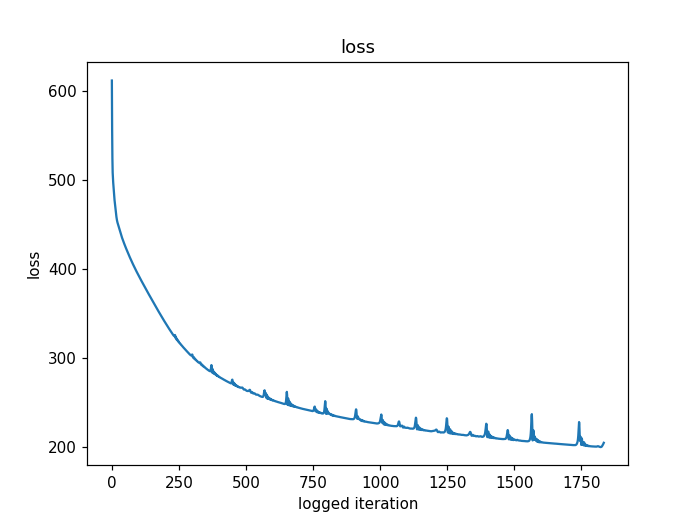

<IPython.core.display.Javascript object>


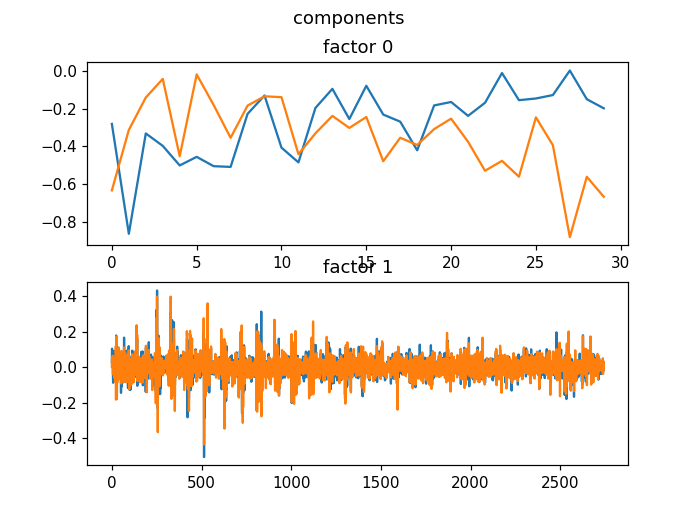

In [26]:
cpmlr.plot_outputs()

In [ ]:
tl.tenalg.inner(X,
                           tl.cp_tensor.cp_to_tensor((weights, list(non_neg_fn(
                                                                                Bcp,
                                                                                non_negative,
                                                                                softplus_kwargs))
                                                     ))[...,None],
                           n_modes=len(Bcp)
                        ).squeeze() + bias

In [ ]:
dataloader_test, dataset_test, sampler_test = tr.util.make_WindowedDataloader(X_test, y_test, win_range=win_range, batch_size=10000, drop_last=True)

In [163]:
X_train = X[cv_idx[0]]

In [164]:
# test = np.array([ cpmlr.predict(dataset_test[ii][0][None,...]) for ii in range(100,20000)])
# y_hat_test = cpmlr.predict(X_test.cpu())
y_hat_test = cpmlr.predict(X_train)

In [161]:
del X_test
gc.collect()
torch.cuda.empty_cache()

In [162]:
del X_train
gc.collect()
torch.cuda.empty_cache()

<IPython.core.display.Javascript object>


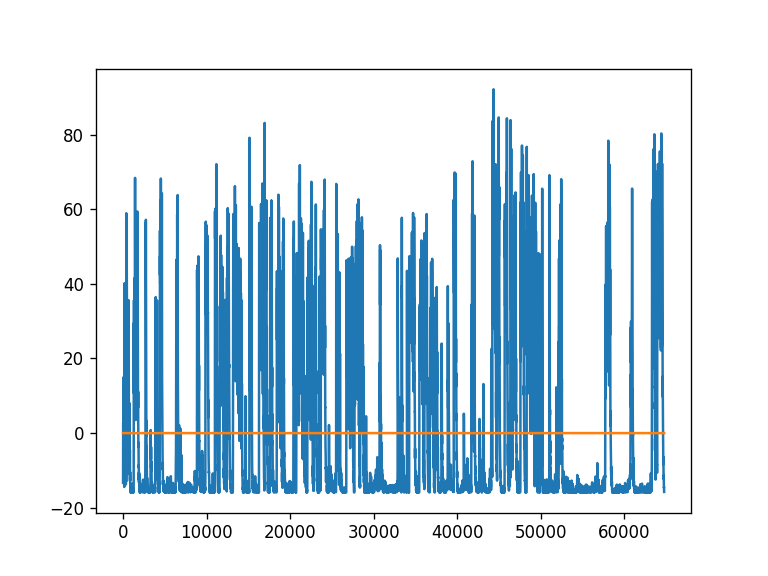

In [165]:
plt.figure()
# plt.plot(y_test)
plt.plot(y_train)
plt.plot(y_hat_test)

In [28]:
path_nwb = r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/FR_run2_20210902/data/session.nwb'

from face_rhythm.util import helpers
helpers.dump_nwb(path_nwb)

import pynwb
from pynwb import NWBHDF5IO

with pynwb.NWBHDF5IO(path_nwb, mode='r') as io:
    file = io.read()
    pts_spaced_convDR = file.processing['Face Rhythm']['Optic Flow']['pts_spaced_convDR'].data[:]

CQT
     Sxx_allPixels:    (1372, 30, 27288, 2)   ,  float32   ,   8.985393 GB
     Sxx_allPixels_norm:    (1372, 30, 27288, 2)   ,  float32   ,   8.985393 GB
     Sxx_allPixels_normFactor:    (27288, 2)   ,  float32   ,   0.000218 GB
     Sxx_xAxis:    (436601,)   ,  float64   ,   0.003493 GB
     freq_idx_toUse:    (30,)   ,  bool   ,   0.0 GB
     freqs_Sxx_all:    (30,)   ,  float64   ,   0.0 GB
     freqs_Sxx_toUse:    (30,)   ,  float64   ,   0.0 GB
Optic Flow
     color_tuples:    (309285, 3)   ,  float64   ,   0.007423 GB
     displacements:    (3102, 2, 436601)   ,  float64   ,   21.669381 GB
     pointInds_toUse:    (3102, 1, 2)   ,  float32   ,   2.5e-05 GB
     positions_cleanup:    (3102, 2, 436601)   ,  float64   ,   21.669381 GB
     positions_cleanup_absolute:    (3102, 2, 436601)   ,  float64   ,   21.669381 GB
     positions_convDR_absolute:    (1372, 2, 436601)   ,  float64   ,   9.584265 GB
     positions_convDR_meanSub:    (1372, 2, 436601)   ,  float64   ,   9.584

<IPython.core.display.Javascript object>


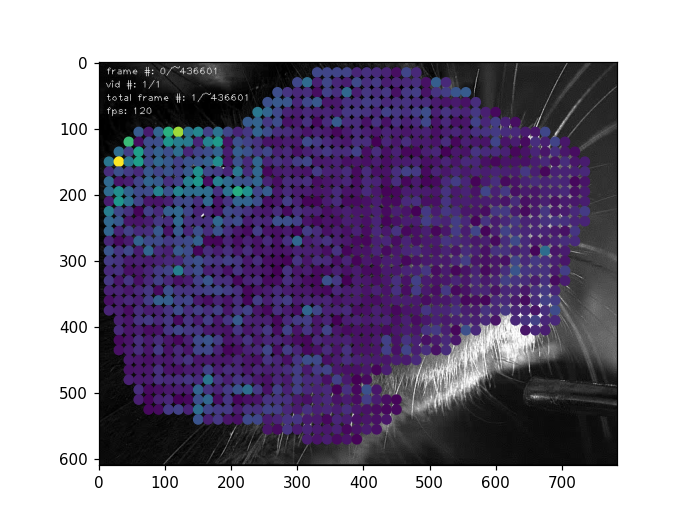

<IPython.core.display.Javascript object>


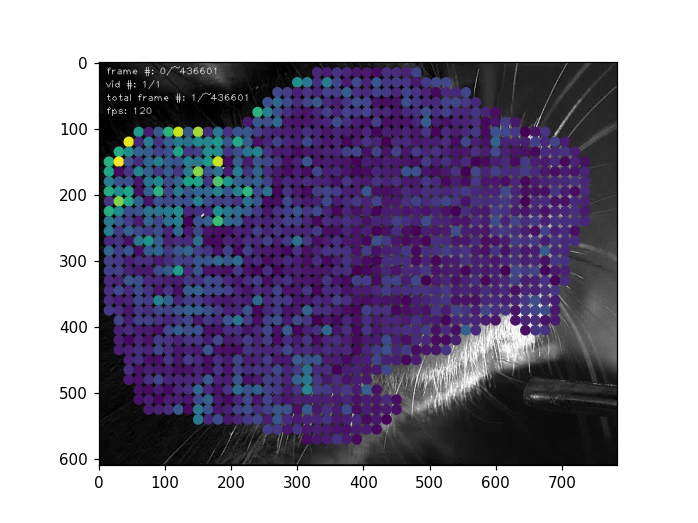

In [29]:
import imageio

c_face_dots = cpmlr.Bcp[1].detach().cpu().numpy()
c_face_dots = c_face_dots.reshape(c_face_dots.shape[0]//2, 2, c_face_dots.shape[1])
cfd_mag = np.linalg.norm(c_face_dots, axis=1)

path_mouse_movie = r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/FR_run2_20210902/viz/just_mouse.avi'

reader = imageio.get_reader(path_mouse_movie)
for i, im in enumerate(reader):
    im_mouse = im
    break

for ii in range(cfd_mag.shape[1]):
    plt.figure()
    plt.imshow(im_mouse)
    plt.scatter(pts_spaced_convDR[:,0,0], pts_spaced_convDR[:,0,1], c=cfd_mag[:,ii])